In [1]:
import tensorflow as tf
import os
import random
import numpy as np

In [2]:
SEED=123456
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC']='1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [3]:
from tensorflow.keras.datasets import fashion_mnist
(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()
assert x_train.shape == (60000,28,28)
assert x_test.shape == (10000,28,28)
assert y_train.shape==(60000,)
assert y_test.shape==(10000,)

4422102/4422102 [==============================] - 1s 0us/step


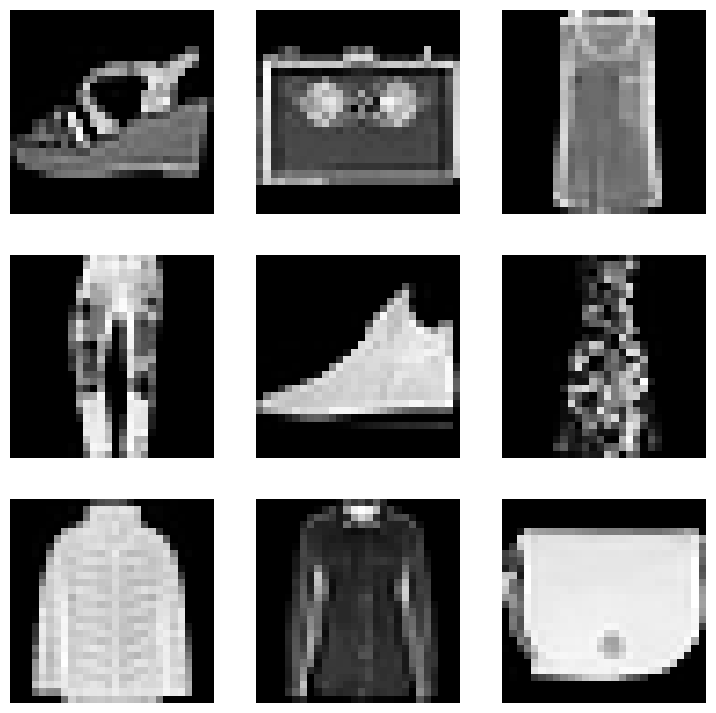

In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(9,9))
rndSamples=np.random.choice(60000,9) ##taking 9 samples out of 60000samples in the train dataset
for i in range(9):
  plt.subplot(3,3,i+1)  ##where 3=no of rows and columns and i=index
  plt.imshow(x_train[rndSamples[i]],cmap='Greys_r')
  plt.axis('off')
plt.show()

In [5]:
dataset=np.concatenate([x_train,x_test],axis=0)
##expand dimmensions and convert images from 28x28 to 28x28x1 as convolutional layers expect 3 channels
dataset=np.expand_dims(dataset,-1).astype('float32')/255

In [6]:
from tensorflow import keras
from tensorflow.keras import layers
class SamplingLayer(layers.Layer):
  def call(self,inputs):
    zMean,zLogVar=inputs
    batch=tf.shape(zMean)[0]
    dim=tf.shape(zMean)[1]
    epsilon=tf.keras.backend.random_normal(shape=(batch,dim))
    return zMean+tf.exp(0.5*zLogVar)*epsilon

In [7]:
def buildEncoder(latentDim,encoderInputs):
  l1=keras.models.Sequential([
      layers.Conv2D(128,3,activation='relu',padding='same',strides=2),
      layers.Conv2D(64,3,activation='relu',padding='same',strides=2),
      layers.Flatten(),
      layers.Dense(256,activation='relu')
  ])
  x=l1(encoderInputs) ##passing the input through convolutional blocks
  zMean=layers.Dense(latentDim,name='z_mean')(x) ##A dedicated layer to learn mean in parallel
  zLogVar=layers.Dense(latentDim,name='z_log_var')(x) ##A dedicated layer to learn variance in parallel
  z=SamplingLayer()([zMean,zLogVar])  ##reparamitrization trick
  return keras.Model(encoderInputs, [zMean,zLogVar,z], name='encoder') ##the actual model takes images as input and returns mean,
                                                                       ## variance and distribution.zMean and zLogVar are not the final outputof
                                                                       ## the encoder but are used in Kullback Leibler Divergence loss
encoderInputs=keras.Input(shape=(28,28,1))###triggering the function to actually build the model
encoder=buildEncoder(2,encoderInputs)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 256)                  878144    ['input_1[0][0]']             
                                                                                                  
 z_mean (Dense)              (None, 2)                    514       ['sequential[0][0]']          
                                                                                                  
 z_log_var (Dense)           (None, 2)                    514       ['sequential[0][0]']          
                                                                                            

In [8]:
def buildDecoder(latentInputs):
  l1=keras.models.Sequential([
      layers.Dense(7*7*64,activation='relu',input_shape=(latentInputs.shape[1],)),
      layers.Reshape((7,7,64)),
      layers.Conv2DTranspose(128,3,strides=2,padding='same',activation='relu'),
      layers.Conv2DTranspose(64,3,strides=2,padding='same',activation='relu'),
      layers.Conv2DTranspose(1,3,padding='same',activation='sigmoid')
  ])
  return keras.Model(latentInputs,l1(latentInputs),name='decoder')
latentInputs=keras.Input(shape=(2,)) ##building the actual model
decoder=buildDecoder(latentInputs)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         157633    
                                                                 
Total params: 157633 (615.75 KB)
Trainable params: 157633 (615.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
def reconstructionLoss(data,reconstructed):
  return tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data,reconstructed),axis=(1,2)))

In [10]:
def klDivergence(zMean,zLogVar):
  return tf.reduce_mean(tf.reduce_sum(-0.5*(1+zLogVar-tf.square(zMean)-tf.exp(zLogVar)),axis=-1))

In [11]:
def calcTotalLoss(data,reconstructed,zMean,zLogVar):
  loss1=reconstructionLoss(data,reconstructed)
  loss2=klDivergence(zMean,zLogVar)
  klWeight=3.0
  return loss1, loss2, loss1+ klWeight*loss2

In [20]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.totalLossTracker = keras.metrics.Mean(name="total_loss")
    self.ceLossTracker = keras.metrics.Mean(name="ce_loss")
    self.klLossTracker = keras.metrics.Mean(name="kl_loss")
  @property
  def metrics(self):
    return [
        self.totalLossTracker,
        self.ceLossTracker,
        self.klLossTracker
    ]

  # calculatING loss + calculate gradients + update weights
  def train_step(self, data):
    # Gradient tape is a recording of all gradients for the trainable
    # weights that need to be updated
    with tf.GradientTape() as tape:
        # forward path
        zMean, zLogVar, z = self.encoder(data)
        reconstruction = self.decoder(z)
        ceLoss, klLoss, totalLoss = calcTotalLoss(data, reconstruction, zMean, zLogVar)
    # backward path
    grads = tape.gradient(totalLoss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.totalLossTracker.update_state(totalLoss)
    self.ceLossTracker.update_state(ceLoss)
    self.klLossTracker.update_state(klLoss)
    return {
        "total_loss": self.totalLossTracker.result(),
        "ce_loss": self.ceLossTracker.result(),
        "kl_loss": self.klLossTracker.result()
    }

In [21]:
model = VAE(encoder, decoder)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [22]:
history = model.fit(dataset, epochs=32, batch_size=128)

Epoch 1/32
547/547 [==============================] - 15s 17ms/step - total_loss: 311.9387 - ce_loss: 300.6049 - kl_loss: 3.7779
Epoch 2/32
547/547 [==============================] - 10s 19ms/step - total_loss: 278.4831 - ce_loss: 264.7519 - kl_loss: 4.5770
Epoch 3/32
547/547 [==============================] - 9s 17ms/step - total_loss: 274.8908 - ce_loss: 260.8387 - kl_loss: 4.6840
Epoch 4/32
547/547 [==============================] - 9s 17ms/step - total_loss: 273.3403 - ce_loss: 259.0193 - kl_loss: 4.7737
Epoch 5/32
547/547 [==============================] - 10s 18ms/step - total_loss: 272.2293 - ce_loss: 257.7402 - kl_loss: 4.8298
Epoch 6/32
547/547 [==============================] - 9s 17ms/step - total_loss: 271.4121 - ce_loss: 256.7586 - kl_loss: 4.8845
Epoch 7/32
547/547 [==============================] - 9s 16ms/step - total_loss: 270.8910 - ce_loss: 256.0790 - kl_loss: 4.9373
Epoch 8/32
547/547 [==============================] - 9s 17ms/step - total_loss: 270.2248 - ce_loss: 

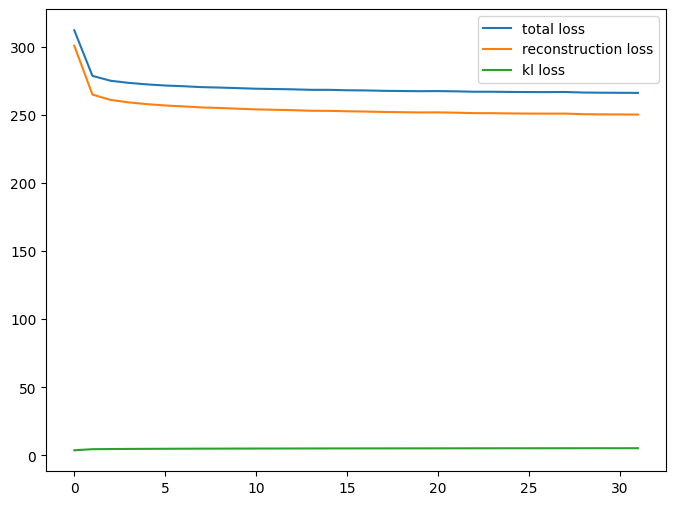

In [24]:
plt.figure(figsize=(8,6))
plt.plot(history.history.get('total_loss'),label='total loss')
plt.plot(history.history.get('ce_loss'),label='reconstruction loss')
plt.plot(history.history.get('kl_loss'),label='kl loss')
plt.legend()

1/1 [==============================] - 0s 399ms/step


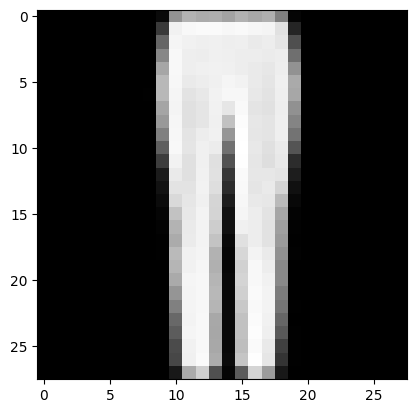

In [25]:
a=model.decoder.predict([[1,2]])
plt.imshow(a.reshape((28,28)),cmap='Greys_r');

8/8 [==============================] - 0s 3ms/step


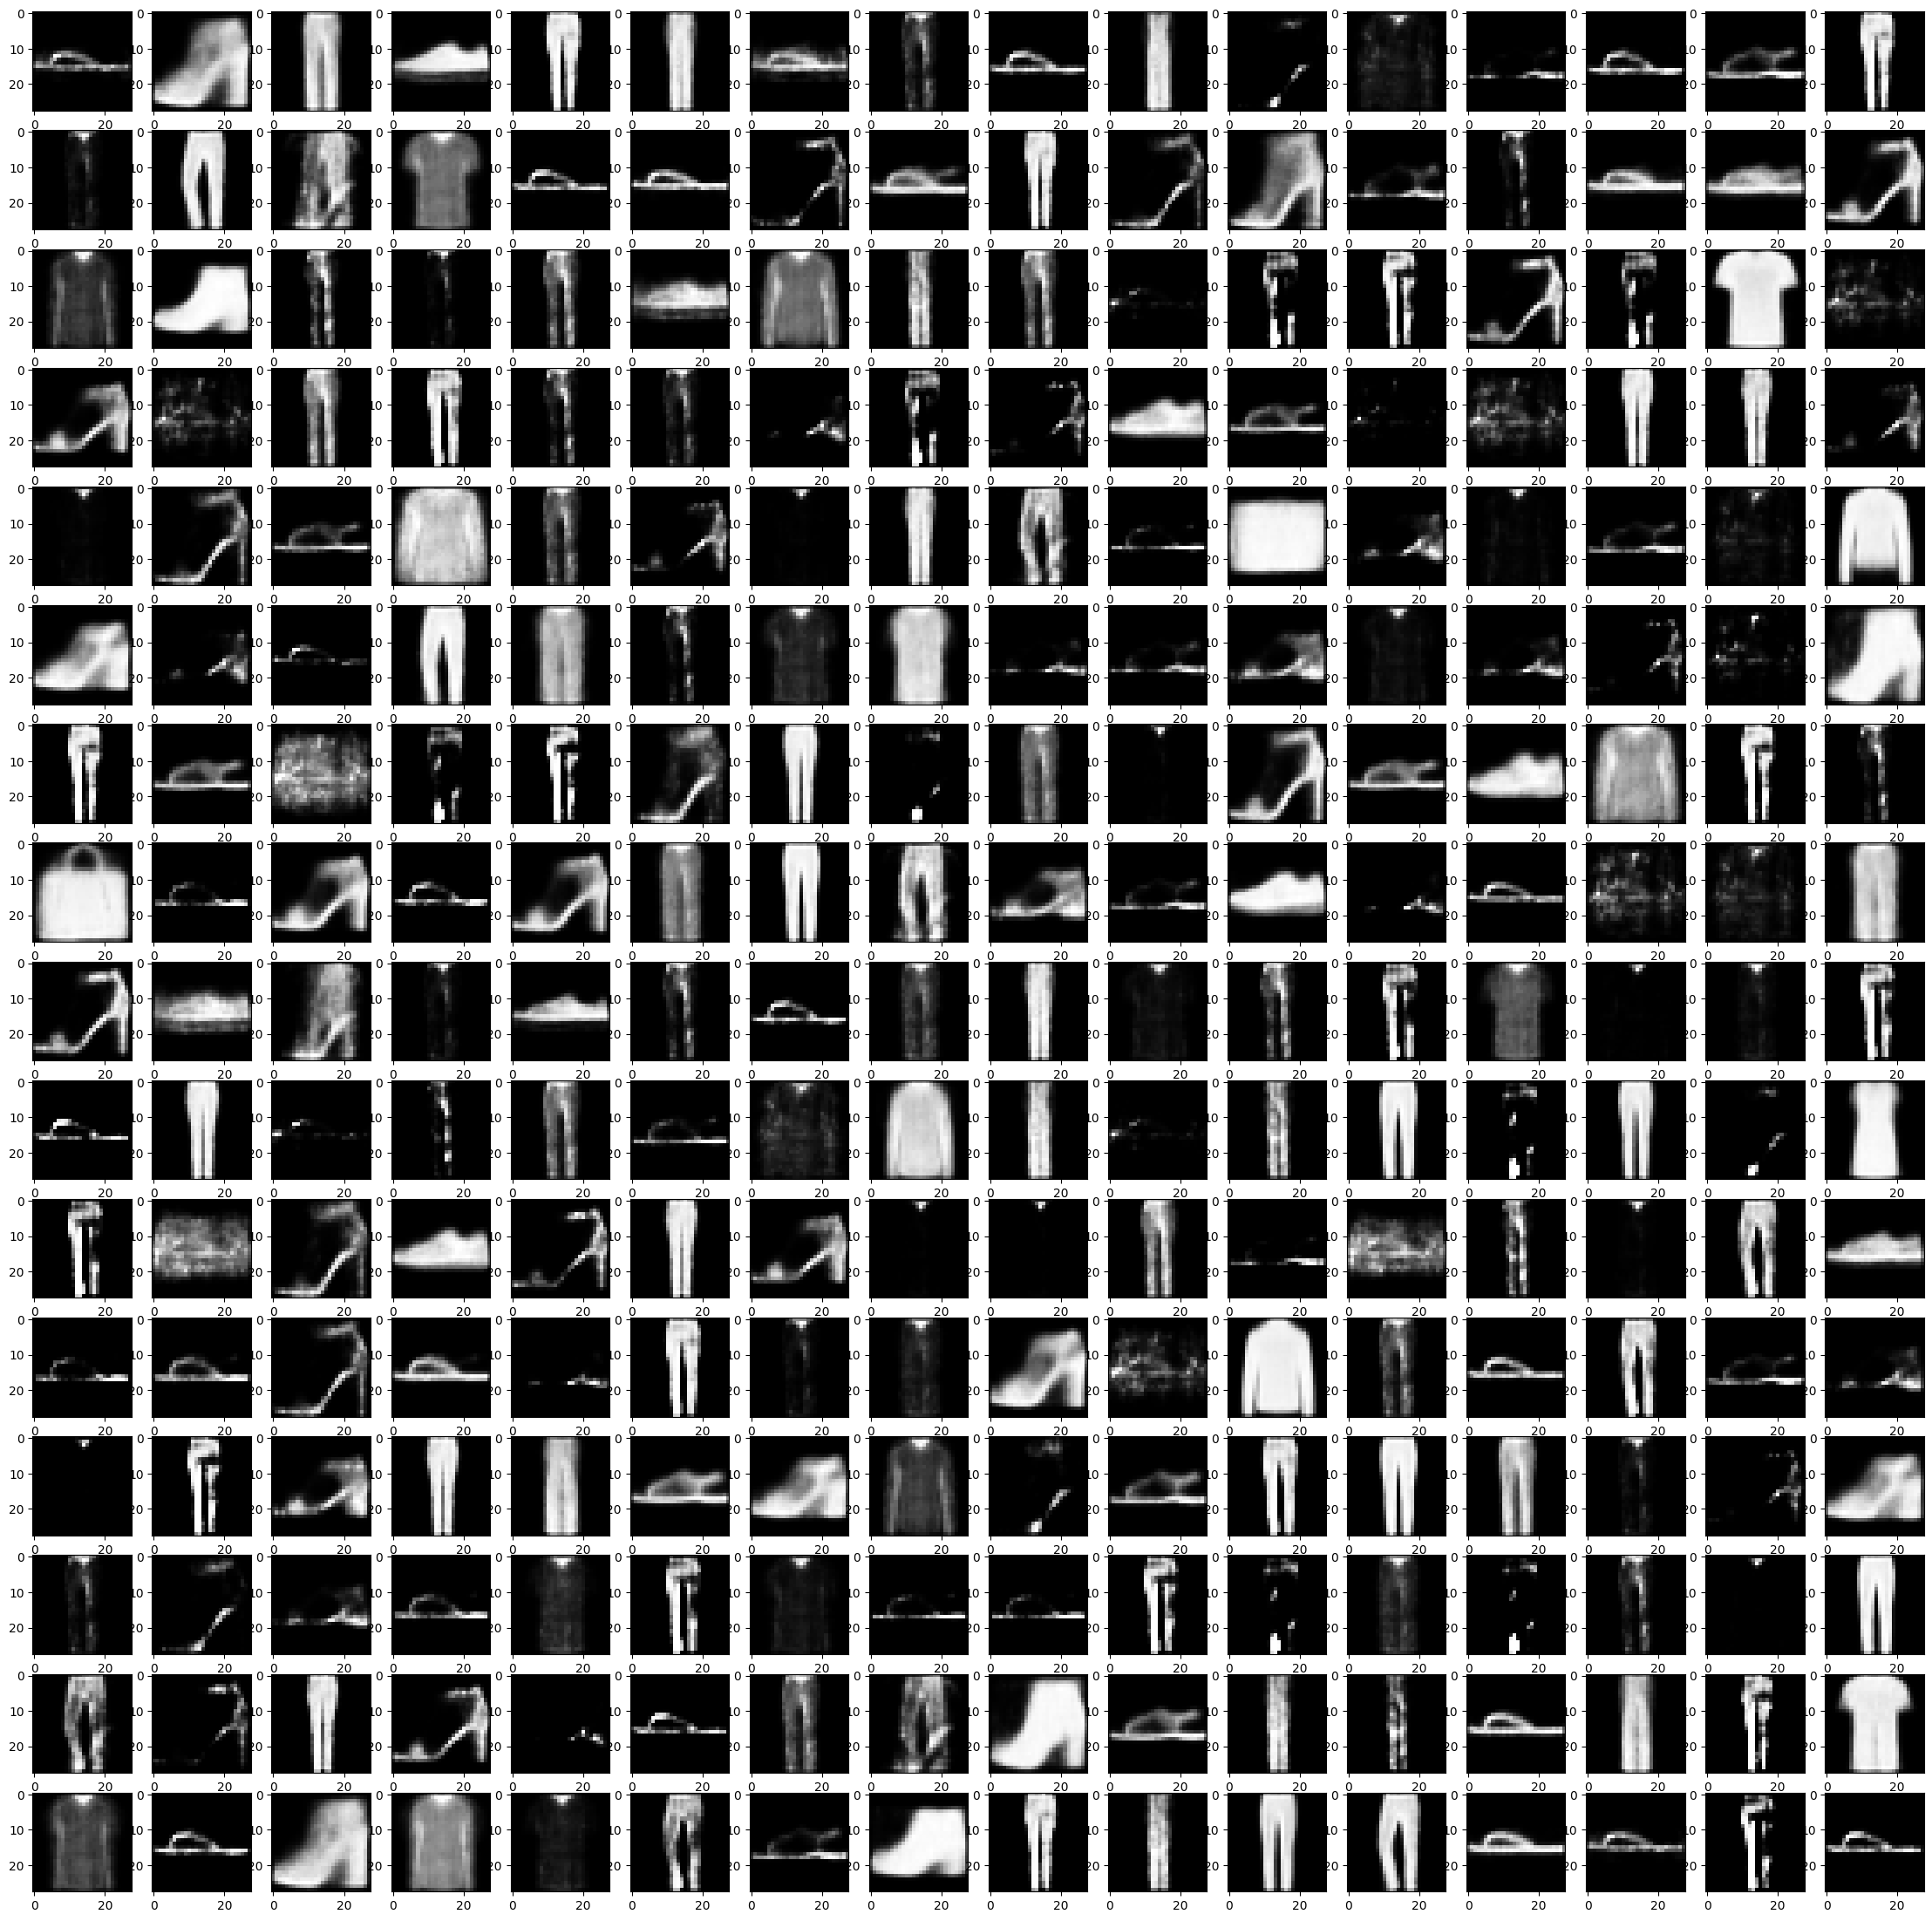

In [26]:
z=np.random.normal(loc=0,scale=4,size=(256,2))
a=model.decoder.predict(z)
plt.figure(figsize=(28,28))
for i in range(256):
  plt.subplot(16,16,i+1)
  plt.imshow(a[i].reshape((28,28)),cmap='Greys_r')
plt.show()

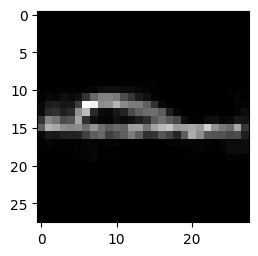

In [28]:
idx=1280
batch=np.expand_dims(x_train[idx],axis=0)
plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.imshow(a[0].reshape((28,28)),cmap='Greys_r')
plt.show()

2188/2188 [==============================] - 4s 2ms/step


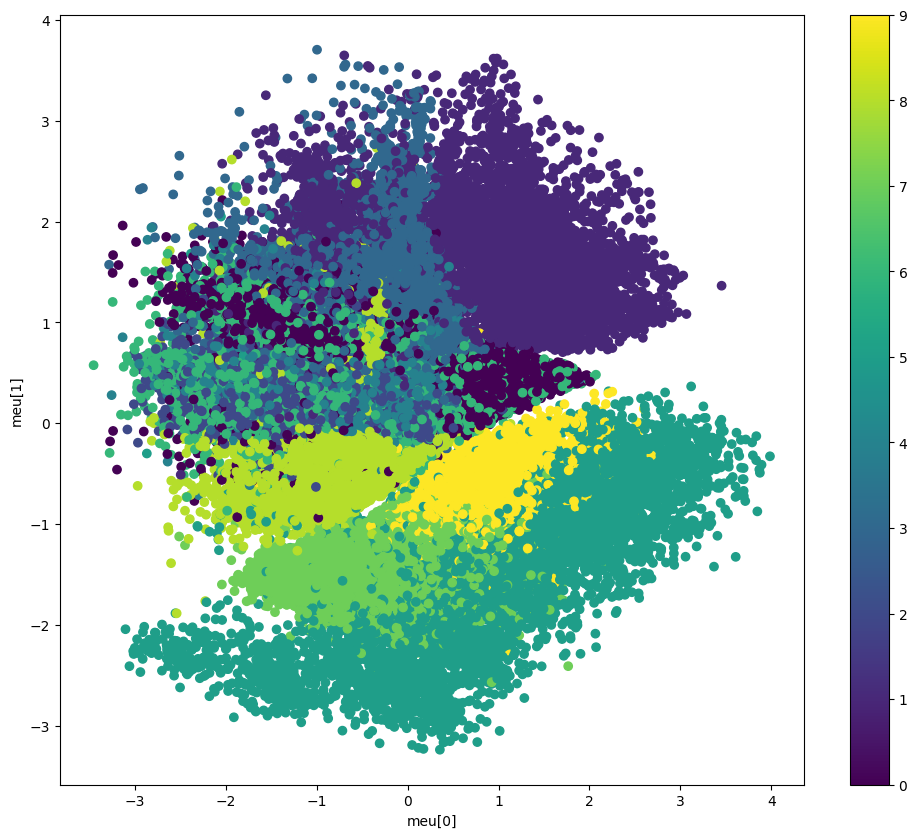

In [29]:
labels=np.concatenate([y_train,y_test],axis=0)
meu,_,_=model.encoder.predict(dataset)
plt.figure(figsize=(12,10))
plt.scatter(meu[:,0],meu[:,1],c=labels)
plt.colorbar()
plt.xlabel('meu[0]')
plt.ylabel('meu[1]')
plt.show()